# Hybrid-MC: SIMIND Data

Hybrid Monte Carlo (MC) SPECT reconstruction. uses SIMIND as a backend. See the website https://simind.blogg.lu.se/exempelsida/ for instructions on how to install, and how to cite their work. Once `simind` has been set as a path variable on your system (one of their install instructions), then you should be able to run the code of this tutorial.

Hybrid MC SPECT reconstruction replaces conventional forward projection $\bar{y} =H \hat{x}$ with an MC prediction $\bar{y}_{\text{MC}} = \hat{H}_{\text{MC}}\hat{x}$. In practice, the term $\hat{H}_{\text{MC}}\hat{x}$ is estimated all at once via simulation of many individual photons; $\hat{H}_{\text{MC}}$ is given a hat because it is effectively estimated using random variables. Unlike conventional reconstruction $\hat{H}_{\text{MC}}$ estimates the contribution from all photons, so a scatter correction term is not required.



In [1]:
import os
import torch
from pytomography.io.SPECT import simind
from pytomography.projectors.SPECT import SPECTSystemMatrix, MonteCarloHybridSPECTSystemMatrix
from pytomography.transforms.SPECT import SPECTAttenuationTransform, SPECTPSFTransform
from pytomography.algorithms import OSEM
from pytomography.likelihoods import PoissonLogLikelihood, MonteCarloHybridSPECTPoissonLogLikelihood
from pytomography.utils import simind_mc
import matplotlib.pyplot as plt

In [2]:
# change this to where the tutorial data is saved
PATH = '/ac225listmode/pytomography_tutorial_data/SPECT/SIMIND-Jaszak'

## Part 1: Opening the data we want to reconstruct

In this tutorial we give the option to reconstruct one of three different isotopes: Lu-177, Pb-212, or Y-90. Conventional reconstruction does a pretty good job for Lu-177, but is less effective for Pb-212 or Y-90. In these cases, you'll find that the MC reconstruction here does much better. You can change the isotope name below

In [3]:
ISOTOPE='lu177'
if ISOTOPE == 'pb212': # NEED TO RUN
    isotopes_decay = ['pb212', 'bi212', 'tl208']
    isotopes_ratios = [1,1.105,0.4] # bateman equation equilibrium
    idx_peak, idx_lower, idx_upper = 5, 4, 6
    E_window_bounds = [[204.6,215.1],[215.1,262.9],[262.9,276.4]] #lwr,peak,upr
    E = 236
    use_TEW_for_conventional = True
    activity_conc = 50
if ISOTOPE == 'lu177': # NEED TO RUN
    isotopes_decay = ['lu177']
    isotopes_ratios = [1]
    idx_peak, idx_lower, idx_upper = 5, 4, 6
    E_window_bounds = [[166.4,187.2],[187.2,228.8],[228.8,249.6]] #lwr,peak,upr
    E = 208
    use_TEW_for_conventional = True
    activity_conc = 1
if ISOTOPE == 'y90': # NEED TO RUN
    isotopes_decay = ['y90']
    isotopes_ratios = [1]
    idx_peak, idx_lower, idx_upper = 2,1,3
    E_window_bounds = [[50,100],[100,200],[200,300]] #lwr,peak,upr
    E = 150
    use_TEW_for_conventional = False
    activity_conc = 10
dT = 15

Now we'll specify the file paths and generate synthetic projections as we've done in the introductory SIMIND reconstruction tutorials. Since the data that we are reconstructing itself comes from SIMIND, the MC reconstruction uses an MC simulator that perfectly encapsulates the true physics.

In [4]:
files_NM = [[os.path.join(PATH, f'{isotope}', f'tot_w{i}.h00') for isotope in isotopes_decay] for i in [idx_lower, idx_peak, idx_upper]]
object_meta, proj_meta = simind.get_metadata(files_NM[0][0])
activity_concs = [activity_conc * ratio for ratio in isotopes_ratios]
projections = simind.get_projections(files_NM, activity_concs)
projections *= dT
projections = torch.poisson(projections)
# the projections are ordered as [lower, peak, upper]
photopeak = projections[1]
widths = torch.tensor([E2-E1 for E1,E2 in E_window_bounds])
if use_TEW_for_conventional:
    additive_TEW = simind.compute_EW_scatter(projections[0], projections[2], widths[0], widths[2], widths[1])
else:
    additive_TEW = photopeak*0

Lets view some of the projections

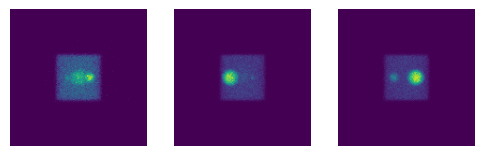

In [5]:
fig, ax = plt.subplots(1,3,figsize=(6,2))
ax[0].imshow(photopeak[0].cpu().T)
ax[1].imshow(photopeak[40].cpu().T)
ax[2].imshow(photopeak[80].cpu().T)
[a.axis('off') for a in ax.ravel()]
plt.show()

Back projection still requires an analytica system matrix, so we need to create the attenuation and PSF transform used in the back projection. We'll choose the mid-point energy in the energy window specified (even though for Y-90, there are photons of many energies detected in this window)

In [6]:
# We need two attenuation maps for MC monte carlo. The 140keV map is used as input
# to the MC forward simulation. The amap at the isotope energy is used to build 
# an attenuation transform that is used in the analytical back projection
amap140keV =  simind.get_attenuation_map(os.path.join(PATH,'attenuation_maps','amap140.hct'))
amapIsotopeEnergy = simind.get_attenuation_map(os.path.join(PATH,'attenuation_maps',f'amap{E}.hct'))
att_transform = SPECTAttenuationTransform(attenuation_map=amapIsotopeEnergy)

psf_meta = simind.get_psfmeta_from_header(files_NM[1][0])
psf_transform = SPECTPSFTransform(psf_meta)

## Part 2: Building the MC system matrix

Now we need to reconstruct the system matrix used for MC forward projection. We need to decide the isotopes to simulate in this simulator. Note that we already specified isotope names above, but that was to create synthetic data. We do this agian below to clearly show that we are now developing a system matrix for reconstruction.
* For Pb-212, three of the daughters need to be simulated, since they all contribute to the 238keV window that we are going to reconstruct.

In [7]:
# note: the collimator name is the one I used to generate the
# projection data
if ISOTOPE == 'pb212':
    isotope_names = ['pb212', 'bi212', 'tl208']
    isotope_ratios = [1, 1.105, 0.4]
    collimator_type = 'SY-HE'
elif ISOTOPE == 'lu177':
    isotope_names = ['lu177']
    isotope_ratios = [1]
    collimator_type = 'SY-ME'
elif ISOTOPE == 'y90':
    isotope_names = ['y90']
    isotope_ratios = [1]
    collimator_type = 'SY-HE'

Now we'll set the scanner parameters used in the MC simulation. These are the same parameters I used to generate the data, so this represents a perfect MC simulation.

In [8]:
cover_thickness = 0.1 # assumed to be aluminum
backscatter_thickness = 6.6 # assumed to be pyrex
# the argument below is optional, only siemens currently implemented.
# if not provided, then assumes energy resolution is proportional to 
# 1/sqrt(E)
advanced_energy_resolution_model='siemens' 
# if the energy resolution model above is not used, then
# the energy resolution needs to be provided at 140keV in
# units of percent.
energy_resolution_140keV = 10 # %
crystal_thickness = 0.9525  # assumed to be NaI

We also need the energy window parameters. Since the projections are ordered [lower,peak,upper], we use an index of 1 to get the photopeak index. It is a good idea to print the energy window params to ensure you are indeed binning photons within the correct energy window during reconstruction.

In [9]:
energy_window_params = simind_mc.get_energy_window_params_simind(files_NM[1])
energy_window_params

['187.1999969482422,228.8000030517578,0']

We also need to choose the number of photons to simulate per projection, as well as the number of parallel CPU jobs to run. I find the 200 million photons per projection works reasonably well for most isotopes. Since I have a powerful computer, I use 90 CPU cores in parallel to run projection (if you have the option, you should select a computer with more CPU power as opposed to GPU power since SIMIND only runs on CPU).
* Change `n_parallel` to how many CPU cores your system has, most have around 8-16.

In [10]:
# this configuration takes around 20min; you can try lowering the number of events
n_events = 200e6
n_parallel = 90

Now we'll build the hybrid system matrix, which performs MC forward projection and analytical back projection

In [11]:
system_matrix = MonteCarloHybridSPECTSystemMatrix(
        object_meta,
        proj_meta,
        obj2obj_transforms=[att_transform, psf_transform],
        proj2proj_transforms=[],
        attenuation_map_140keV=amap140keV,
        energy_window_params=energy_window_params,
        primary_window_idx=0, # index of energy_window_params to use
        isotope_names=isotope_names,
        isotope_ratios=isotope_ratios,
        collimator_type=collimator_type,
        crystal_thickness=crystal_thickness,
        cover_thickness=cover_thickness,
        backscatter_thickness=backscatter_thickness,
        advanced_energy_resolution_model=advanced_energy_resolution_model,
        advanced_collimator_modeling=True, # include septal penetration/scatter
        n_events=n_events,
        n_parallel=n_parallel
    )

Now we define the likelihood and algorithm and reconstruct.
* A new likelihood function is used that prevents divergence from finite number of photons being simulated in the MC simulation

In [12]:
likelihood = MonteCarloHybridSPECTPoissonLogLikelihood(system_matrix, photopeak)
algorithm = OSEM(likelihood)
# for now just 1 iteration but you can change. Takes about 20min to run with 90CPU cores
recon_MC = algorithm(n_iters=1, n_subsets=16)

We can also compare to an analytical reconstruction approach

In [13]:
system_matrix = SPECTSystemMatrix(
        obj2obj_transforms=[att_transform, psf_transform],
        proj2proj_transforms=[],
        object_meta=object_meta,
        proj_meta=proj_meta,
    )
likelihood = PoissonLogLikelihood(system_matrix, photopeak, additive_TEW)
algorithm = OSEM(likelihood)
recon_analytical = algorithm(n_iters=1, n_subsets=16)

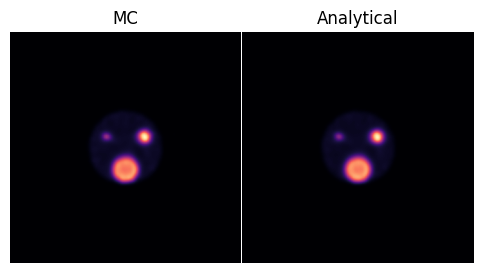

In [14]:
fig, ax = plt.subplots(1,2,figsize=(6,3), gridspec_kw={'wspace':0.0})
ax[0].imshow(recon_MC[:,:,64].cpu().T, interpolation='gaussian', cmap='magma')
ax[0].set_title('MC')
ax[1].imshow(recon_analytical[:,:,64].cpu().T, interpolation='gaussian', cmap='magma')
ax[1].set_title('Analytical')
[a.axis('off') for a in ax.ravel()]
plt.show()
